<a href="https://colab.research.google.com/github/weso500/QMLIIOT/blob/main/QSVM_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00


In [6]:
pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.2.2
    Uninstalling qiskit-2.2.2:
      Successfully uninstalled qiskit-2.2.2


In [29]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

dimension = 8
feature_map = ZZFeatureMap(feature_dimension=dimension, reps=2, entanglement="full")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [30]:
import pandas as pd
import numpy as np

# Load the training data
train_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/pca_train_features.csv')

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/pca_test_features_with_target.csv')

# Convert training features to numpy array and select 100 samples
train_features = train_df.to_numpy()[:100]

# Separate test features and target
test_features_all = test_df.drop(columns=['target']).to_numpy()
test_target_all = test_df['target'].to_numpy()

# Separate normal and anomalous samples from the test set
normal_test_features = test_features_all[test_target_all == 0]
anomalous_test_features = test_features_all[test_target_all == 1]

# Select 55 normal and 5 anomalous samples for the test set
test_features = np.concatenate((normal_test_features[:55], anomalous_test_features[:5]))
test_target = np.concatenate((np.zeros(55), np.ones(5)))

# Ensure arrays are of size samples*8 (assuming 8 is the number of features)
print(f"Shape of train_features: {train_features.shape}")
print(f"Shape of test_features: {test_features.shape}")
print(f"Shape of test_target: {test_target.shape}")

Shape of train_features: (100, 8)
Shape of test_features: (60, 8)
Shape of test_target: (60,)


In [31]:
matrix_train = kernel.evaluate(x_vec=train_features)
matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

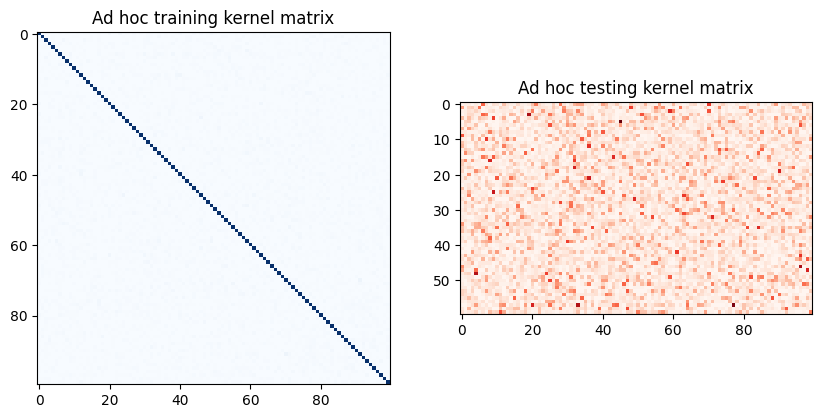

In [32]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [59]:
import numpy as np
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='precomputed', nu=0.08, gamma='auto')  # nu = anomaly proportion
ocsvm.fit(matrix_train)

OneClassSVM(gamma='auto', kernel='precomputed', nu=0.08)

In [60]:
predictions = ocsvm.predict(matrix_test)

In [61]:
from sklearn.metrics import classification_report

print(classification_report(test_target, predictions))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       0.0
         0.0       0.00      0.00      0.00      55.0
         1.0       0.00      0.00      0.00       5.0

    accuracy                           0.00      60.0
   macro avg       0.00      0.00      0.00      60.0
weighted avg       0.00      0.00      0.00      60.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

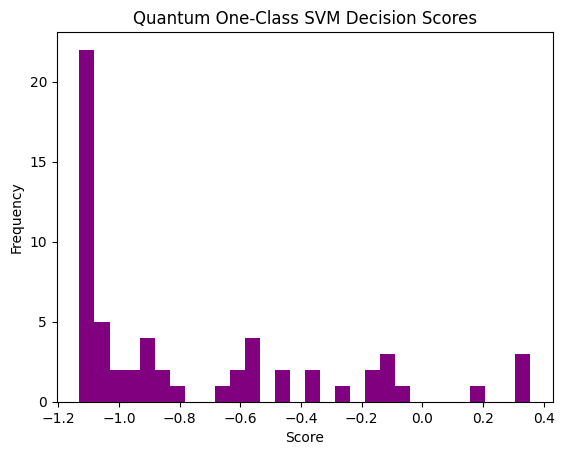

In [62]:
scores = ocsvm.decision_function(matrix_test)

plt.hist(scores, bins=30, color='purple')
plt.title("Quantum One-Class SVM Decision Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [63]:
scores = scores * -1

In [64]:
print(scores)

[ 0.61368906  1.13010132  0.92100192  1.06683486  0.85734826  0.9116173
  0.90823511  0.12248563 -0.34810378  0.48510547 -0.33857859  1.05734157
  1.13010137  1.13010137  1.10223209  0.60554624  1.08778214 -0.18175559
  0.14257143  0.54077091  1.12941818  0.36248344  1.13010137  1.08849655
  1.13010137  0.0988792   1.13010137  1.06546523  1.07747575  0.07366068
  1.08962242  0.88307067  1.13010137  0.86633335  1.05397351  1.10129603
  0.25112731  1.09854984  0.79046361  0.67747308  0.12197427  1.13010137
  1.0201321   1.13010137  0.16528742  0.57587508  1.13010137  0.96919403
 -0.35566012  0.57828641  0.54741177  0.36391985  1.00199424  0.47604675
  0.94887618  1.13010137  1.13010137  1.13010137  1.13010137  1.13010137]


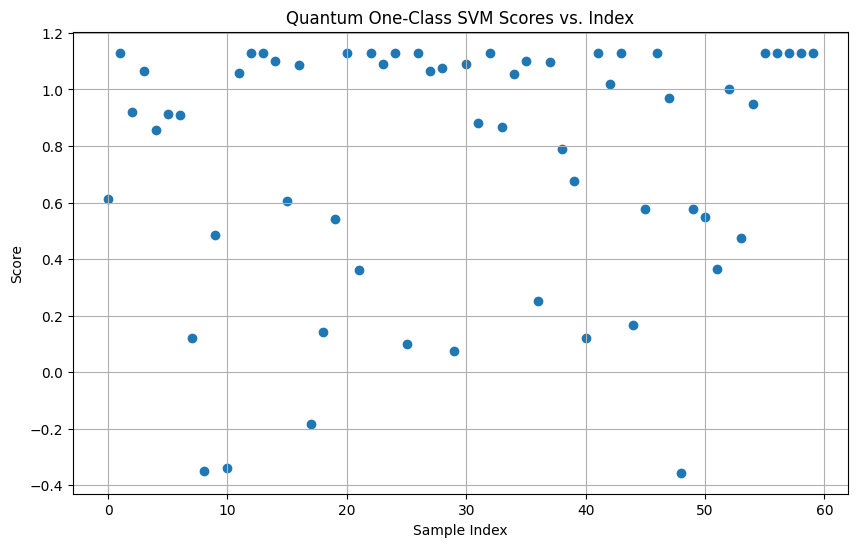

In [65]:
import matplotlib.pyplot as plt

# Create a scatter plot of scores vs. index
plt.figure(figsize=(10, 6))
plt.scatter(range(len(scores)), scores)
plt.title("Quantum One-Class SVM Scores vs. Index")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.grid(True)
plt.show()

In [66]:
from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC score
# Note: roc_auc_score expects the target to be binary (0 or 1)
# and the scores to represent the probability of the positive class (or a score where higher values indicate the positive class).
# In One-Class SVM, the decision_function usually outputs negative values for inliers and positive for outliers.
# We want higher scores to indicate anomalies (target = 1), so multiplying by -1 in the previous step was correct.
roc_auc = roc_auc_score(test_target, scores)

print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.9272727272727272


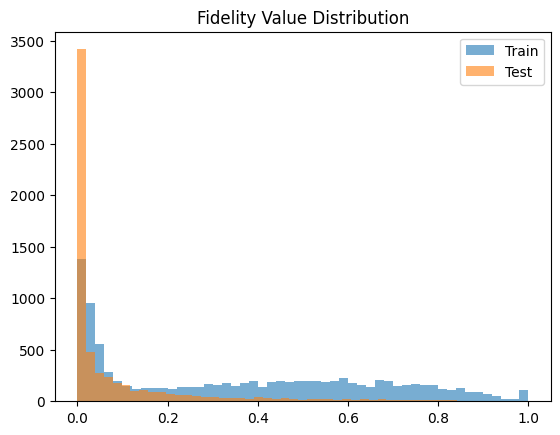

In [67]:
plt.hist(matrix_train.flatten(), bins=50, alpha=0.6, label='Train')
plt.hist(matrix_test.flatten(), bins=50, alpha=0.6, label='Test')
plt.legend()
plt.title("Fidelity Value Distribution")
plt.show()

In [68]:
from sklearn.metrics.pairwise import rbf_kernel
matrix_train_rbf = rbf_kernel(train_features)
matrix_test_rbf = rbf_kernel(test_features, train_features)

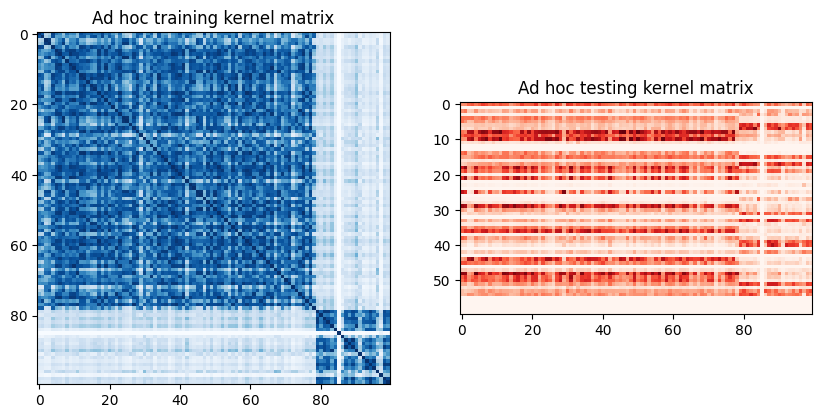

In [69]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train_rbf), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test_rbf), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [70]:
import numpy as np
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='precomputed', nu=0.08, gamma='auto')  # nu = anomaly proportion
ocsvm.fit(matrix_train_rbf)

OneClassSVM(gamma='auto', kernel='precomputed', nu=0.08)

In [71]:
predictions = ocsvm.predict(matrix_test_rbf)

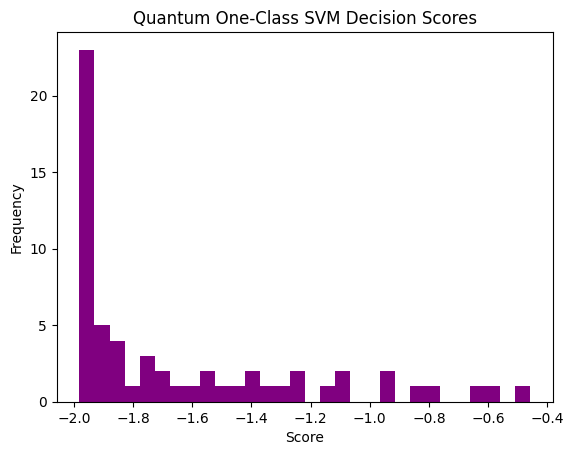

In [72]:
scores = ocsvm.decision_function(matrix_test)

plt.hist(scores, bins=30, color='purple')
plt.title("Quantum One-Class SVM Decision Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [73]:
scores = scores * -1

In [74]:
from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC score
# Note: roc_auc_score expects the target to be binary (0 or 1)
# and the scores to represent the probability of the positive class (or a score where higher values indicate the positive class).
# In One-Class SVM, the decision_function usually outputs negative values for inliers and positive for outliers.
# We want higher scores to indicate anomalies (target = 1), so multiplying by -1 in the previous step was correct.
roc_auc = roc_auc_score(test_target, scores)

print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.9272727272727272


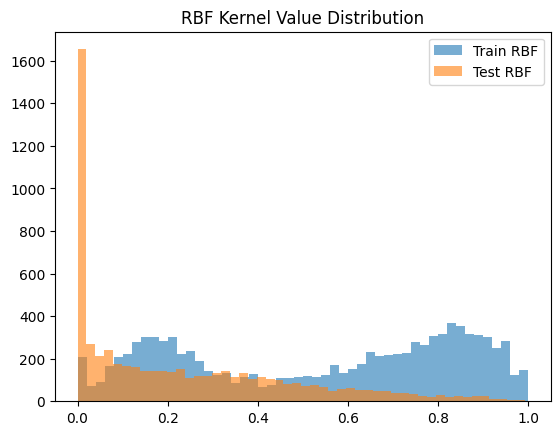

In [75]:
plt.hist(matrix_train_rbf.flatten(), bins=50, alpha=0.6, label='Train RBF')
plt.hist(matrix_test_rbf.flatten(), bins=50, alpha=0.6, label='Test RBF')
plt.legend()
plt.title("RBF Kernel Value Distribution")
plt.show()